# Model to analyse Trust in Online Services that Require Aadhaar Verification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Loading the dataset
df = pd.read_csv("Survey_ Trust in Online Services that Require Aadhaar Verification   (Responses) - Form Responses 1.csv")

# Printing actual column names for verification
print("Actual columns in dataset:")
print(df.columns.tolist())

Actual columns in dataset:
['How frequently do you use online services that require Aadhaar verification? ', ' Which of these online services have you used that required Aadhaar verification? (Select all that apply)  ', '  Have you ever faced issues while using Aadhaar for verification?  ', '  If you faced issues, what were they? (Select all that apply)  ', '  Have you ever avoided using an online service because it required Aadhaar verification?  ', 'Do you trust online services with your Aadhaar details?', 'Have you ever worried about Aadhaar data being misused or leaked?', 'Which aspect of Aadhaar-based verification concerns you the most?', 'Do you believe private companies should have access to Aadhaar verification?', 'Do you feel confident that Aadhaar biometric authentication is secure?', 'Would you prefer an alternative to Aadhaar for identity verification?', 'If yes, which alternative would you prefer?', 'Would you support a law that limits private companies from accessing Aadh

# Data Cleaning 

In [2]:
drop_cols = []
possible_drop_cols = [
    "Name:", "UID:", "Department",
    "Any additional comments or concerns?",
    "If yes, which alternative would you prefer?",
    "Would you prefer an alternative to Aadhaar for identity verification?"
]
for col in possible_drop_cols:
    if col in df.columns:
        drop_cols.append(col)
df.drop(columns=drop_cols, inplace=True)

# Handling missing values
for col in df.columns:
    if df[col].isnull().any():
        df[col].fillna(df[col].mode()[0], inplace=True)

In [3]:
# Helper function to find columns by partial name

def find_col(partial_name):
    matches = [col for col in df.columns if partial_name.lower() in col.lower()]
    return matches[0] if matches else None

# Data Visualizations

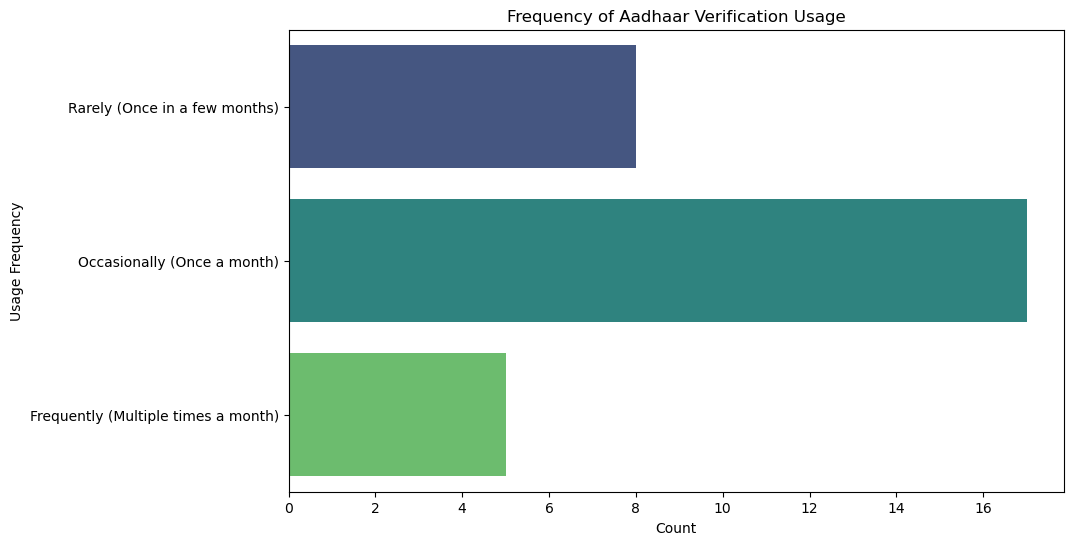

In [4]:
# Visualization 1: Usage Frequency Distribution

usage_col = find_col('How frequently')
if usage_col:
    plt.figure(figsize=(10,6))
    usage_order = ['Rarely (Once in a few months)', 'Occasionally (Once a month)', 
                   'Frequently (Multiple times a month)']
    sns.countplot(data=df, y=usage_col, order=usage_order, palette='viridis')
    plt.title('Frequency of Aadhaar Verification Usage')
    plt.xlabel('Count')
    plt.ylabel('Usage Frequency')
    plt.show()

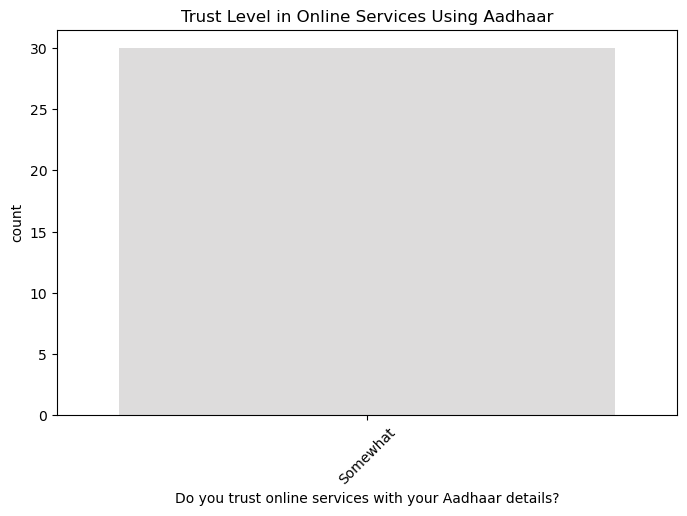

In [5]:
# Visualization 2: Trust Level Distribution

trust_col = find_col('trust online services')
if trust_col:
    plt.figure(figsize=(8,5))
    sns.countplot(data=df, x=trust_col, palette='coolwarm')
    plt.title('Trust Level in Online Services Using Aadhaar')
    plt.xticks(rotation=45)
    plt.show()

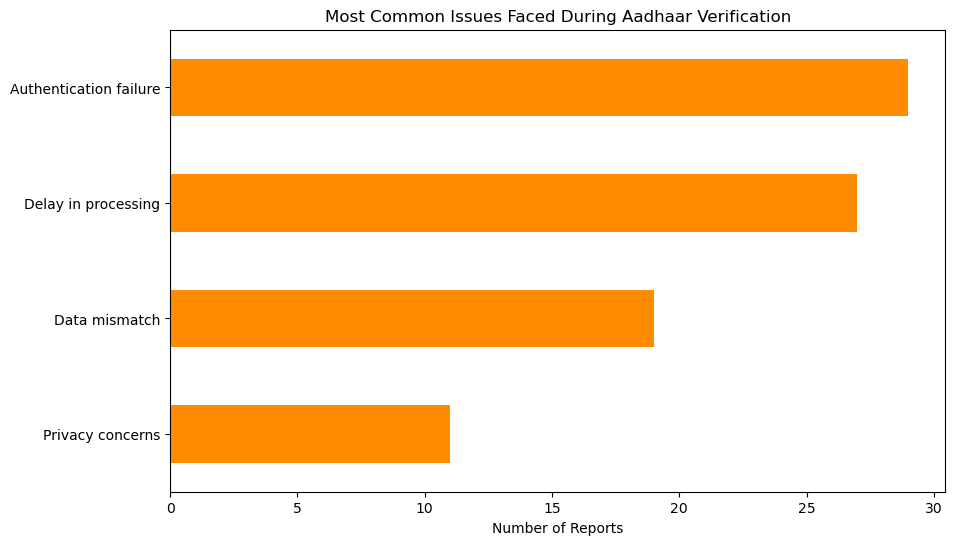

In [6]:
# Visualization 3: Common Issues Faced

issues_col = find_col('If you faced issues')
if issues_col:
    issues = df[issues_col].str.split(', ')
    all_issues = [item for sublist in issues.dropna().apply(lambda x: [i.strip() for i in x]) for item in sublist]
    issue_counts = Counter(all_issues)

    plt.figure(figsize=(10,6))
    pd.Series(issue_counts).sort_values().plot(kind='barh', color='darkorange')
    plt.title('Most Common Issues Faced During Aadhaar Verification')
    plt.xlabel('Number of Reports')
    plt.show()

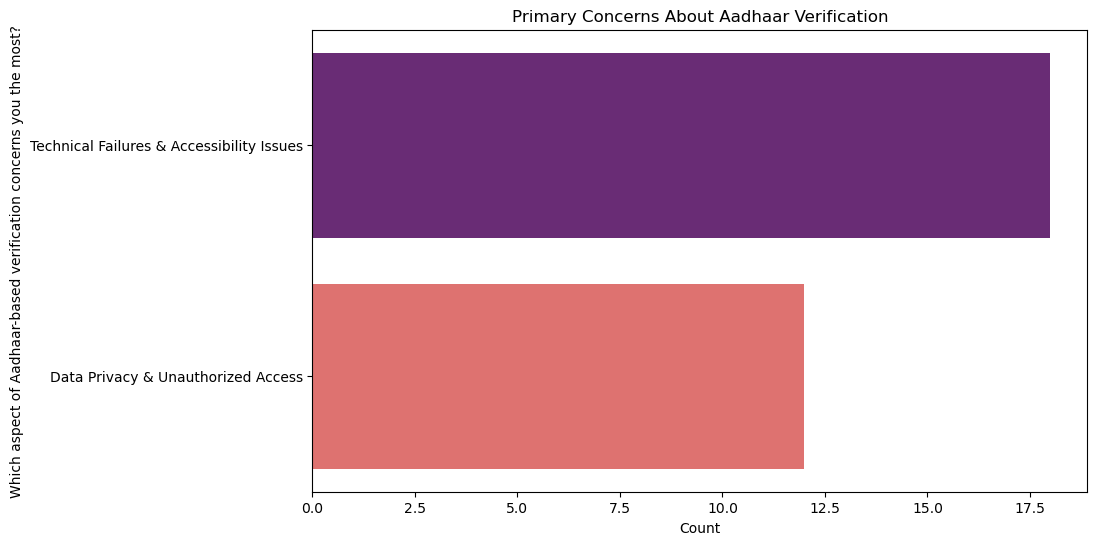

In [7]:
# Visualization 4: Primary Concerns

concern_col = find_col('aspect of Aadhaar')
if concern_col:
    plt.figure(figsize=(10,6))
    concern_order = df[concern_col].value_counts().index
    sns.countplot(data=df, y=concern_col, order=concern_order, palette='magma')
    plt.title('Primary Concerns About Aadhaar Verification')
    plt.xlabel('Count')
    plt.show()


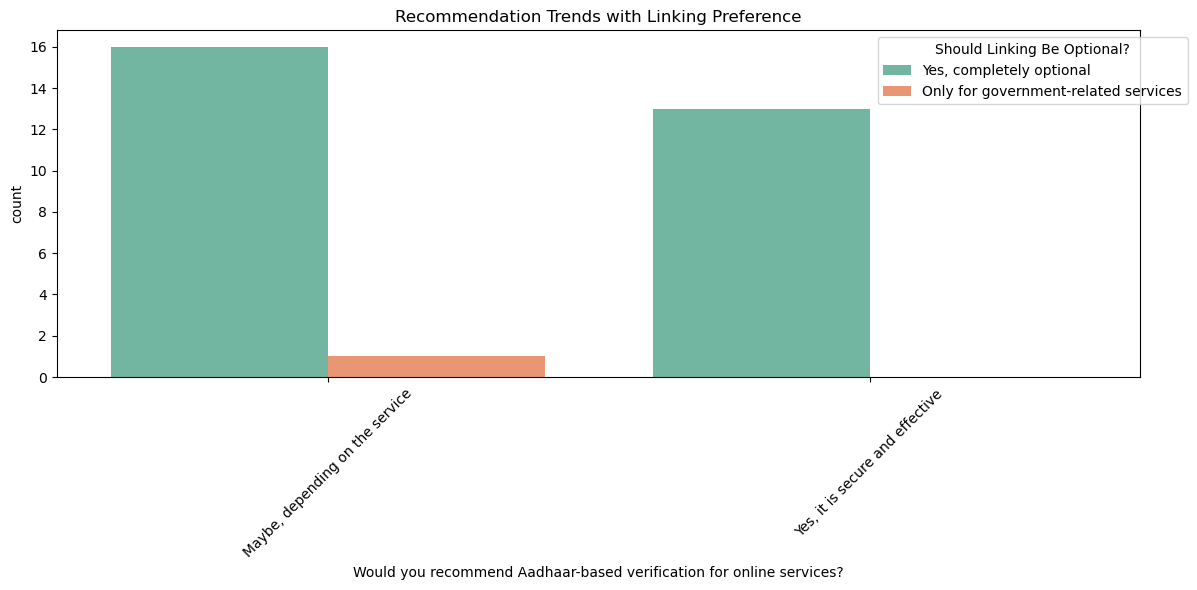

In [8]:
# Visualization 5: Recommendation Trends

recommend_col = find_col('recommend Aadhaar')
optional_col = find_col('linking Aadhaar')
if recommend_col and optional_col:
    plt.figure(figsize=(12,6))
    sns.countplot(data=df, x=recommend_col, hue=optional_col, palette='Set2')
    plt.title('Recommendation Trends with Linking Preference')
    plt.xticks(rotation=45)
    plt.legend(title='Should Linking Be Optional?', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

# Data Preparation (Encoding, Imputing, Defining split ratios)

In [9]:
target_col = find_col('recommend Aadhaar')
if target_col:
    label_encoders = {}
    for col in df.columns:
        if df[col].dtype == 'object':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            label_encoders[col] = le

X = df.drop(columns=[target_col])
y = df[target_col]


imputer = SimpleImputer(strategy='most_frequent')
X = imputer.fit_transform(X)


split_ratios = [
    (0.4, "60-40"),  # 60% train, 40% test
    (0.3, "70-30"),  # 70% train, 30% test
    (0.2, "80-20"),  # 80% train, 20% test
    (0.15, "85-15"), # 85% train, 15% test
]

results = []

# Applying best model (Logistic Regression)

In [10]:
for test_size, ratio_name in split_ratios:
    print(f"\n{'='*40}")
    print(f"Evaluating {ratio_name} split ratio")
    print(f"{'='*40}")
    
    # Splitting data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    # Imputing missing values
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    # Training model
    log_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    log_model.fit(X_train, y_train)
    
    # Predicting and evaluating
    y_pred = log_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Storing results
    results.append({
        'ratio': ratio_name,
        'test_size': test_size,
        'accuracy': accuracy,
        'model': log_model,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred
    })
    
    # Printing results
    print(f"\nAccuracy: {accuracy * 100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


Evaluating 60-40 split ratio

Accuracy: 41.67%

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.43      0.46         7
           1       0.33      0.40      0.36         5

    accuracy                           0.42        12
   macro avg       0.42      0.41      0.41        12
weighted avg       0.43      0.42      0.42        12


Evaluating 70-30 split ratio

Accuracy: 44.44%

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.40      0.44         5
           1       0.40      0.50      0.44         4

    accuracy                           0.44         9
   macro avg       0.45      0.45      0.44         9
weighted avg       0.46      0.44      0.44         9


Evaluating 80-20 split ratio

Accuracy: 50.00%

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       0.

In [11]:
# Finding the best performing split ratio

best_result = max(results, key=lambda x: x['accuracy'])
print(f"\n{'='*40}")
print(f"Best performance: {best_result['ratio']} split with {best_result['accuracy']*100:.2f}% accuracy")
print(f"{'='*40}")


Best performance: 85-15 split with 60.00% accuracy


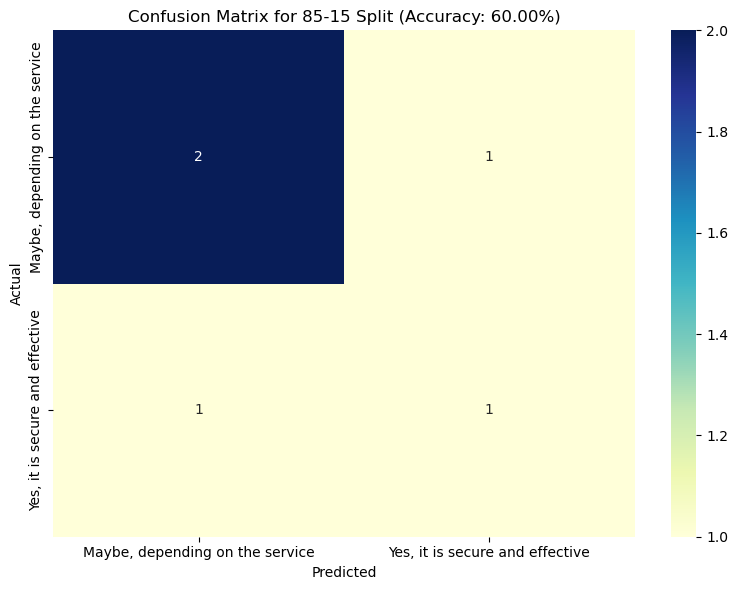

In [12]:
# Plotting confusion matrix for best result

plt.figure(figsize=(8, 6))
sns.heatmap(
    confusion_matrix(best_result['y_test'], best_result['y_pred']), 
    annot=True, fmt='d', cmap='YlGnBu',
    xticklabels=label_encoders[target_col].classes_,
    yticklabels=label_encoders[target_col].classes_
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix for {best_result['ratio']} Split (Accuracy: {best_result['accuracy']*100:.2f}%)")
plt.tight_layout()
plt.show()

In [13]:
# Result Comparison

print("\nPerformance across all split ratios:")
for res in results:
    print(f"{res['ratio']} split: {res['accuracy']*100:.2f}% accuracy")


Performance across all split ratios:
60-40 split: 41.67% accuracy
70-30 split: 44.44% accuracy
80-20 split: 50.00% accuracy
85-15 split: 60.00% accuracy
